In [18]:
import numpy as np
from ctypes import *
import matplotlib.pyplot as plt

from optic.dsp.core import upsample, pnorm, pulseShape, firFilter
from optic.comm.modulation import modulateGray
from optic.plot import eyediagram

### Tests the generation of a random bit sequence

In [19]:
outFile = "/home/silas/Documents/GitHub/TDI/src/dsp.so"
dsp = CDLL(outFile)

dsp.getRandomBits.argtypes = [c_int]
dsp.getRandomBits.restype  = POINTER(c_int)

(400000,)

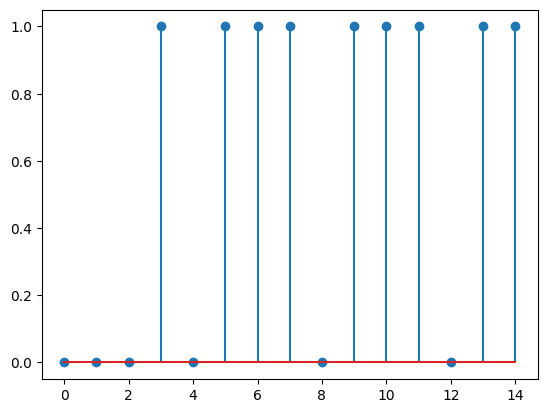

In [20]:
M = 16
Nbits = int(1e5*np.log2(M))

bits   = dsp.getRandomBits(Nbits, M)
# converte o ponteiro para um array numpy
bitsTx = np.ctypeslib.as_array(bits, shape=(Nbits,))

# imprime as primeiras 10 amostras de Nbits
plt.stem(bitsTx[0:15]);
bitsTx.shape

### Test for normalization in power

In [21]:
# Definindo a estrutura para representar números complexos
class Complex(Structure):
    _fields_ = [("real", c_float),
                ("imaginary", c_float)]

# funções auxiliares.
def complex2ctypes(numbers):
    return (Complex * len(numbers))(*(Complex(*index) for index in numbers))

def pointer2complex(arr, length):
    return [(arr[i].real, arr[i].imaginary) for i in range(length)]

def tuple2numpy(arr):
    return np.array([complex(x[0], x[1]) for x in arr], dtype=np.complex64)

npArrayTypeComplex = np.ctypeslib.ndpointer(dtype=np.complex64, flags="C_CONTIGUOUS")

### Define complex numbers as tuples

In [22]:
dsp.pnorm.restype = POINTER(Complex)            
dsp.pnorm.argtypes = [POINTER(Complex), c_int]

nums = [(1.0, 2.0), (3.0, 4.0)]     # define uma tuple como 1.0+2j, 3.0+4.0j
nums_array = complex2ctypes(nums)   # compatível com <complex.h>

result_ptr = dsp.pnorm(nums_array, len(nums))
result_ptr = pointer2complex(result_ptr, len(nums))

### Define complex numbers as numpy array

In [23]:
dsp.pnorm.restype = POINTER(Complex)
dsp.pnorm.argtypes = [npArrayTypeComplex, c_int]

nums = np.array([1.0 + 2.0j, 3.0 + 4.0j], dtype=np.complex64)

# chame a função pnorm
result_ptr = dsp.pnorm(nums, len(nums))
result_ptr = np.ctypeslib.as_array(result_ptr, shape=(nums.size,))

# compare o resultado
print(f"C code: {tuple2numpy(result_ptr)} \nOptiCommPy: {pnorm(np.array([1.0+2.0j, 3.0+4.0j]))}")

C code: [0.2581989+0.5163978j 0.7745967+1.0327955j] 
OptiCommPy: [0.25819889+0.51639778j 0.77459667+1.03279556j]


# Simulation 4-QAM

In [52]:
# define a simulação com ordem de parada em upsampling
dsp.mainUpSymbols.restype  = POINTER(Complex)
dsp.mainUpSymbols.argtypes = [c_int, c_int]
# definindo o filtro FIR
dsp.firFilter.restype  = POINTER(Complex)
dsp.firFilter.argtypes = [npArrayTypeComplex, npArrayTypeComplex, c_int, c_int]
# filtro casado
dsp.matchedFilter.restype  = POINTER(Complex)
dsp.matchedFilter.argtypes = [npArrayTypeComplex, npArrayTypeComplex, c_int, c_int]

In [53]:
M = 4
SpS = 16
Rs = 100e6         # Taxa de símbolos [símbolo/s]
Ts = 1/Rs          # Período de símbolo em segundos
Fa = 1/(Ts/SpS)    # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa          # Período de amostragem

# define o comprimento do bitstream
Nbits = int(1e3*np.log2(M))

symbolsUp = dsp.mainUpSymbols(Nbits, SpS)
symbolsUp = np.ctypeslib.as_array(symbolsUp, shape=(int((Nbits/2)*SpS),))
symbolsUp = tuple2numpy(symbolsUp)

len(symbolsUp)

16000

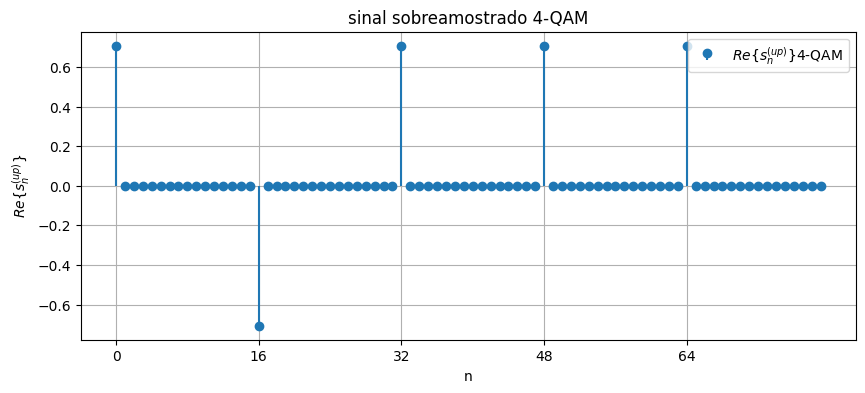

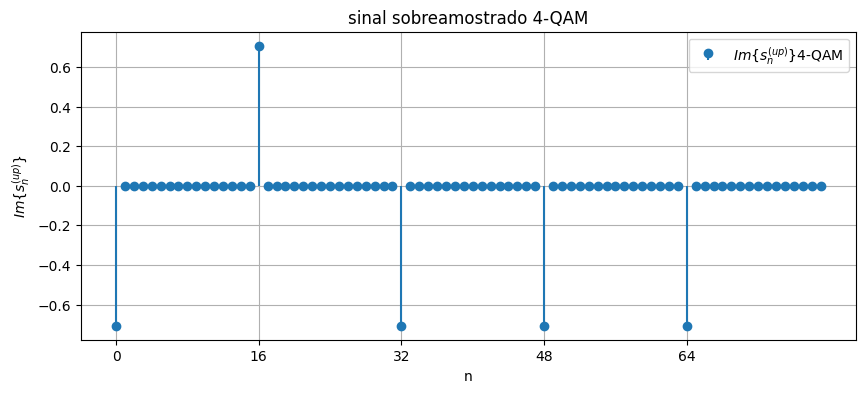

In [54]:
plt.figure(1, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].real, basefmt=" ", label ='$Re\{s_n^{(up)}\}$'+str(M)+'-QAM')
plt.xlabel('n')
plt.ylabel('$Re\{s_n^{(up)}\}$')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-QAM')
plt.grid();

plt.figure(2, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].imag, basefmt=" ", label ='$Im\{s_n^{(up)}\}$'+str(M)+'-QAM')
plt.xlabel('n')
plt.ylabel('$Im\{s_n^{(up)}\}$')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-QAM')
plt.grid();

In [55]:
# pulso NRZ típico
pulse = pulseShape('rc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))
pulse = np.array(pulse, dtype="complex64")

sigTx = dsp.firFilter(symbolsUp, pulse, symbolsUp.size, pulse.size)
sigTx = np.ctypeslib.as_array(sigTx, shape=(symbolsUp.size,))
sigTx = tuple2numpy(sigTx)

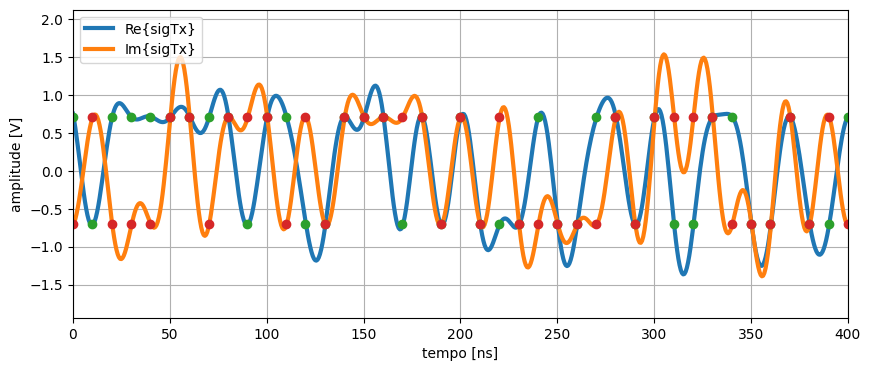

In [56]:
t = np.arange(0, sigTx.size)*(Ta)/1e-9

# instantes centrais de sinalização.
symbolsUp[symbolsUp==0+1j*0] = np.nan + 1j*np.nan

plt.figure(1, figsize=(10, 4))
plt.plot(t, sigTx.real, '-', linewidth=3, label='Re{sigTx}')
plt.plot(t, sigTx.imag, '-', linewidth=3, label='Im{sigTx}')
plt.plot(t, symbolsUp.real, 'o') 
plt.plot(t, symbolsUp.imag, 'o') 
plt.xlim(min(t), 400)
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude [V]')
plt.legend(loc='upper left')
plt.grid(True)

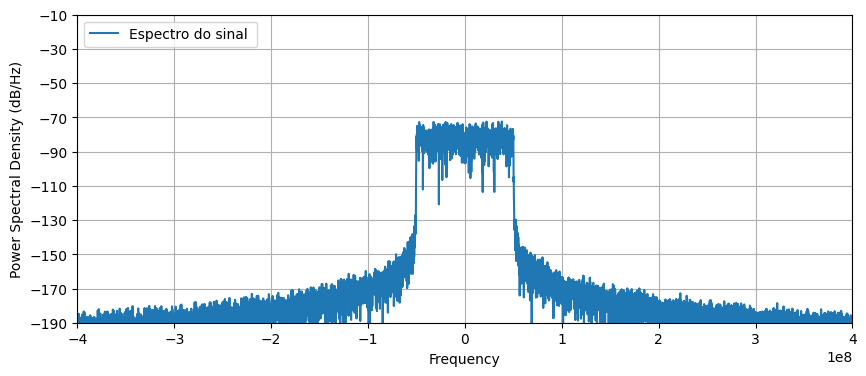

In [57]:
# plot psd
plt.figure(figsize=(10, 4))
plt.xlim(-4*Rs, 4*Rs)
plt.ylim(-190, -10)
plt.psd(sigTx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal ')
plt.legend(loc='upper left');

In [58]:
# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.025 # variância
μ   = 0      # média

σ      = np.sqrt(σ2*SpS) 
ruido  = 1/np.sqrt(2)*(np.random.normal(μ, σ, Namostras) + 1j*np.random.normal(μ, σ, Namostras))

sigCh = sigTx + ruido

/home/silas/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/silas/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


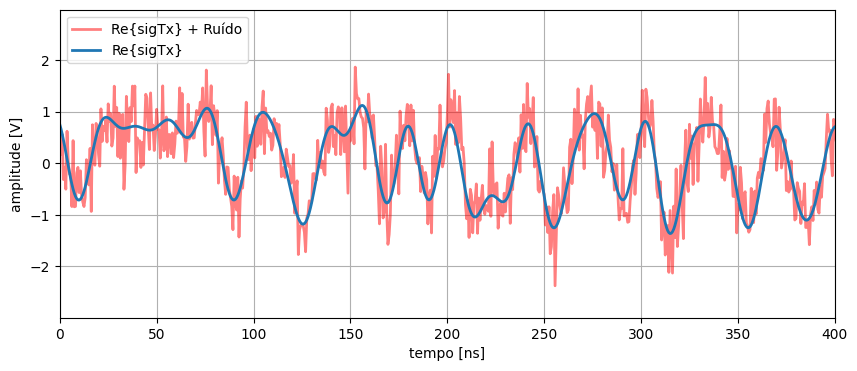

In [59]:
t = np.arange(0, sigTx.size)*(Ta)/1e-9

plt.figure(None, figsize=(10, 4))
plt.plot(t, sigTx.real + ruido, '-', linewidth=2, alpha=0.5, label='Re{sigTx} + Ruído', color='r')
plt.plot(t, sigTx.real, '-', linewidth=2, label='Re{sigTx}')
plt.xlim(min(t), 400)
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude [V]')
plt.legend(loc='upper left')
plt.grid(True);

In [60]:
sigRx = dsp.matchedFilter(np.array(sigCh, dtype="complex64"), pulse, sigCh.size, pulse.size)
sigRx = np.ctypeslib.as_array(sigRx, shape=(sigCh.size,))
sigRx = tuple2numpy(sigRx)

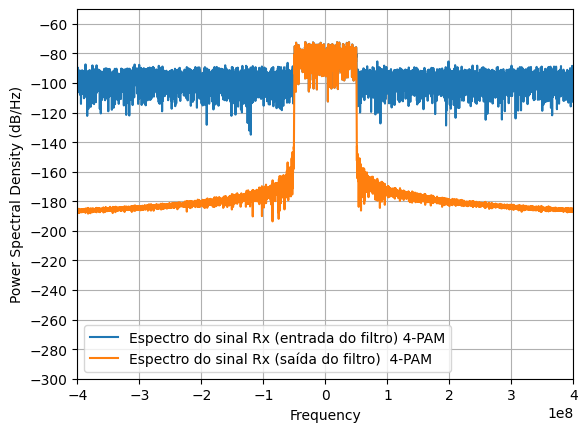

In [61]:
# plot PSD
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-300,-50);
plt.psd(sigTx+ruido,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (entrada do filtro) '+ str(M) +'-PAM')
plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do filtro)  '+ str(M) +'-PAM')
plt.legend(loc='lower left');